# **Installing Spark and set up environment**

**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!curl -O https://raw.githubusercontent.com/deepjavalibrary/d2l-java/master/tools/fix-colab-gpu.sh && bash fix-colab-gpu.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   155  100   155    0     0    775      0 --:--:-- --:--:-- --:--:--   775
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!curl -O https://raw.githubusercontent.com/deepjavalibrary/d2l-java/master/tools/colab_build.sh && bash colab_build.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   520  100   520    0     0   3636      0 --:--:-- --:--:-- --:--:--  3636
Update environment...
Install Java...
Install Jupyter java kernel...


**Install Java**

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

**Downloading Spark**

In [5]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

**Extracting Spark file**

In [6]:
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

**Installing** **FindSpark**

In [7]:
!pip install -q findspark

**Setting up Environment for Spark and Java**

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

**Import FindSpark**

In [9]:
import findspark
findspark.init()

In [10]:
findspark.find()

'/content/spark-3.1.1-bin-hadoop3.2'

In [11]:
ls

colab_build.sh  fix-colab-gpu.sh  sample_data/
d2l-java/       ijava-kernel/     spark-3.1.1-bin-hadoop3.2/
drive/          ijava-kernel.zip  spark-3.1.1-bin-hadoop3.2.tgz


**Creating Spark Session**

In [12]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [13]:
spark

In [14]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-06-21 08:28:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.83.211.184, 3.214.38.12, 3.219.55.35, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.83.211.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  35.7MB/s    in 0.4s    

2021-06-21 08:28:33 (35.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


**Check the directory**

In [15]:
ls -l

total 269544
-rw-r--r--  1 root root       520 Jun 21 08:27 colab_build.sh
drwxr-xr-x 26 root root      4096 Jun 21 08:27 d2l-java/
drwx------  6 root root      4096 Jun 21 08:27 drive/
-rw-r--r--  1 root root       155 Jun 21 08:27 fix-colab-gpu.sh
drwxr-xr-x  3 root root      4096 Jun 21 08:27 ijava-kernel/
-rw-r--r--  1 root root   3366077 Jun 21 08:27 ijava-kernel.zip
-rwxr-xr-x  1 root root  30053267 May  4 14:20 ngrok*
-rw-r--r--  1 root root  13832437 Jun 21 08:28 ngrok-stable-linux-amd64.zip
drwxr-xr-x  1 root root      4096 Jun 15 13:37 sample_data/
drwxr-xr-x 13 1000 1000      4096 Feb 22 02:11 spark-3.1.1-bin-hadoop3.2/
-rw-r--r--  1 root root 228721937 Feb 22 02:45 spark-3.1.1-bin-hadoop3.2.tgz


**Checking Spark version**

In [16]:
spark.version

'3.1.1'

 # **Build ML model**

Load the concatenated **pIC50** and **low-varianced data**.

In [17]:
df_concat = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Preprocessed Data/rat/rat_merged_pIC50_preprocessed_low_variance.csv",header=True,inferSchema=True)
df_concat.show()

+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------

**Examine the data dimension**

In [18]:
print((df_concat.count(), len(df_concat.columns)))

(1448, 205)


## **Code for converting the data to dense vector**

In [19]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select(indexCol,'features','label')

In [20]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

**Convert the concatenated data to dense vector**

In [21]:
transformed_concat = transData(df_concat)
transformed_concat.show(10)

+--------------------+-----------+
|            features|      label|
+--------------------+-----------+
|[0.0,0.0,0.0,0.0,...|        4.0|
|[0.0,0.0,0.0,1.0,...|3.698970004|
|[0.0,0.0,0.0,0.0,...|3.585026652|
|[0.0,0.0,0.0,0.0,...| 4.22184875|
|[0.0,0.0,0.0,1.0,...|3.698970004|
|[0.0,0.0,0.0,0.0,...|3.080921908|
|[0.0,0.0,0.0,1.0,...|3.337242168|
|[0.0,0.0,0.0,1.0,...|        3.0|
|[0.0,0.0,0.0,1.0,...|3.259637311|
|[0.0,0.0,0.0,1.0,...|3.602059991|
+--------------------+-----------+
only showing top 10 rows



**Deal with categorical variable**

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed_concat)

data = featureIndexer.transform(transformed_concat)
data.show(5,True)

+--------------------+-----------+--------------------+
|            features|      label|     indexedFeatures|
+--------------------+-----------+--------------------+
|[0.0,0.0,0.0,0.0,...|        4.0|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,1.0,...|3.698970004|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,0.0,...|3.585026652|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...| 4.22184875|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,1.0,...|3.698970004|[0.0,0.0,0.0,1.0,...|
+--------------------+-----------+--------------------+
only showing top 5 rows



## **Splitting the dataset into traning set and test set (80%, 20%)**

In [23]:
train_df_concat, test_df_concat = data.randomSplit([0.8,0.2],seed=100)

In [24]:
train_df_concat.show(5)
test_df_concat.show(5)

+--------------------+-----------+--------------------+
|            features|      label|     indexedFeatures|
+--------------------+-----------+--------------------+
|[0.0,0.0,0.0,0.0,...|3.585026652|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|3.050609993|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...| 4.22184875|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|4.161150909|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|3.080921908|[0.0,0.0,0.0,0.0,...|
+--------------------+-----------+--------------------+
only showing top 5 rows

+--------------------+-----------+--------------------+
|            features|      label|     indexedFeatures|
+--------------------+-----------+--------------------+
|[0.0,0.0,0.0,0.0,...|  2.8569852|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|6.838631998|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|6.441291429|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|7.494850022|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|5.896196279|[0.0,0.0,0.0,0.0,...|
+--------------------+-

Dimension for **training set**

In [25]:
print("Dimension for training set:",(train_df_concat.count(), len(train_df_concat.columns)))

Dimension for training set: (1185, 3)


Dimension for **test set**

In [26]:
print("Dimension for test set: ",(test_df_concat.count(), len(test_df_concat.columns)))

Dimension for test set:  (263, 3)


## **Build and train random forest regression model**

Import libraries

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [28]:
feature_list = []
for col in transformed_concat.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [39]:
# Define LinearRegression algorithm
rf = RandomForestRegressor(featuresCol="features", numTrees=100, maxDepth = 15, seed=42) # featuresCol="indexedFeatures",numTrees=2, maxDepth=2, seed=42
#rf = RandomForestRegressor(featuresCol="features", numTrees=200, maxDepth = 25, seed=42) # featuresCol="indexedFeatures",numTrees=2, maxDepth=2, seed=42

Pipeline architecture

In [40]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(train_df_concat)

In [41]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [47]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=10)

In [48]:
cvModel = crossval.fit(train_df_concat)

Make a prediction

In [49]:
predictions = cvModel.transform(test_df_concat)

predictions.select("label", "prediction").show(20)

+-----------+-----------------+
|      label|       prediction|
+-----------+-----------------+
|  2.8569852|4.119151843157229|
|6.838631998|6.686101552468147|
|6.441291429|6.586580105148605|
|7.494850022|4.470546371645212|
|5.896196279|4.237562513169444|
|5.031517051|4.838831233993471|
|        4.0|4.310676332656844|
|        3.0|3.654558339621787|
|4.444905551|4.349166362872167|
|6.583359493|4.319468756150225|
|7.408935393|4.704150187147987|
|4.294992041|4.215006011380414|
|5.455931956| 4.74364334230481|
|        4.0|4.262960762734605|
|        4.0|4.262960762734605|
|        4.0|4.157163365110024|
|4.760950907|3.975579989448336|
|4.187755303|4.774137865706925|
|5.886056648|4.887577040670639|
|6.060980224|6.625994876737757|
+-----------+-----------------+
only showing top 20 rows



In [ ]:
predictions.toPandas().to_csv("asdasd.csv")

Evaluation for the model

In [50]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.931572


In [51]:
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.5307505717744452


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

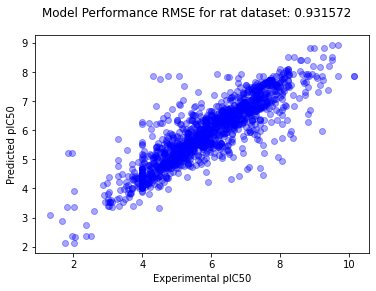

In [53]:
rfPred = cvModel.transform(data)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo', alpha = 0.35)
plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
plt.suptitle("Model Performance RMSE for rat dataset: %f" % rmse)
plt.savefig("prediction_pIC50_rat.jpg")

plt.show()

Text(0.5, 1.0, 'Feature Importances')

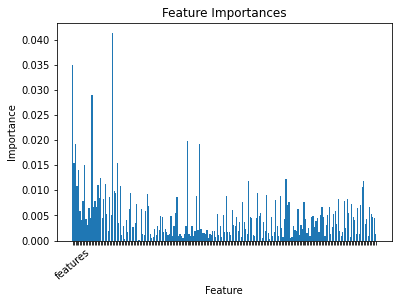

In [54]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [55]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  50
maxDepth -  15
